In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
import imageio
import os

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
%cd 'drive/MyDrive/GitHub/master-thesis'

[Errno 2] No such file or directory: 'drive/MyDrive/GitHub/master-thesis'
/content/drive/MyDrive/GitHub/master-thesis


In [71]:
from clustering.utils import *

# Import Data

In [72]:
#%cd ..

In [73]:
df = pd.read_csv("data/clustering/220407_gmm_clustered_grouped_data_2.csv")

In [74]:
#behaviour_cols = get_behaviour_cols()
#behaviour_cols = get_behaviour_cols_combined()
behaviour_cols = get_grouped_behaviour_cols()

# Silhouette Coefficient
Metric used to evaluate and compare cluster performance

The Silhouette Coefficient is defined for each sample and is composed of two scores:

a: The mean distance between a sample and all other points in the same class.

b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient s for a single sample is then given as:

s=(b-a)/max(a,b)


The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample.

In [75]:
from sklearn import metrics

df_sample = df.sample(20000) # used only for quick results, must be changed back to only df to get real score

X = df_sample[behaviour_cols].to_numpy()
labels = df_sample.group.to_numpy()
metrics.silhouette_score(X, labels, metric='euclidean')

0.03755957786955537

Scores:
- GMM 3 Cluster 0.00359
- GMM 7 Cluster: -0.0439
- GMM PCA 5 Cluster: -0.02312
- GMM PCA 2 Cluster: 0.046
- k-means PCA 2 Cluster: 0.064
- k-means 2 Cluster: 0.174

# Filter interesting columns

In [76]:
df_group_means = df[behaviour_cols + ['group']].copy()
df_group_means[behaviour_cols] = (df_group_means[behaviour_cols]-df_group_means[behaviour_cols].min())/(df_group_means[behaviour_cols].max()-df_group_means[behaviour_cols].min())
df_group_means.describe()

,group_q2_following_advice,group_q2_consequence_advice,group_q3_cleaning,group_q3_distancing,group_q5_beh_other,group_q6_opinion,group_q4_contacts,group
count,124119.000000,124119.000000,124119.000000,124119.000000,124119.000000,124119.000000,124119.000000,124119.000000
mean,0.787257,0.479462,0.788766,0.767699,0.586945,0.711508,0.164495,1.480418
std,0.215215,0.287974,0.208034,0.212761,0.245586,0.223980,0.193669,1.123270
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.708333,0.250000,0.666667,0.638889,0.416667,0.583333,0.020833,1.000000
50%,0.833333,0.500000,0.833333,0.805556,0.583333,0.750000,0.083333,1.000000
75%,0.958333,0.666667,1.000000,0.944444,0.750000,0.900000,0.229167,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [77]:
pca = False
if pca:
  pc_col =  []
  for i in np.arange(11):
    col_name = 'PC_' + str(i)
    pc_col.append(col_name)
  df_group_means = df[pc_col + ['group']].copy()

In [78]:
df_group_means = df_group_means.groupby('group').mean().reset_index().transpose()
df_group_means.drop('group', inplace=True)
df_group_means.reset_index(inplace=True)
df_group_means['std'] = df_group_means.std(axis=1)
df_group_means = df_group_means.sort_values(by='std', ascending=False)
df_group_means.iloc[:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,index,0,1,2,3,std
0,group_q2_following_advice,0.847342,0.832134,0.482520,0.860229,0.182386
2,group_q3_cleaning,0.668709,0.764391,0.649679,1.000000,0.160900
3,group_q3_distancing,0.633157,0.824184,0.600950,0.909274,0.148858
5,group_q6_opinion,0.729145,0.727558,0.499494,0.800903,0.131063
6,group_q4_contacts,0.220856,0.049965,0.344680,0.150904,0.123836
4,group_q5_beh_other,0.528312,0.621436,0.489182,0.651316,0.076379
1,group_q2_consequence_advice,0.454996,0.499570,0.510727,0.457386,0.028647


In [79]:
top_cols = df_group_means['index'].tolist()
top_cols

['group_q2_following_advice',
 'group_q3_cleaning',
 'group_q3_distancing',
 'group_q6_opinion',
 'group_q4_contacts',
 'group_q5_beh_other',
 'group_q2_consequence_advice']

# Answers Distributions

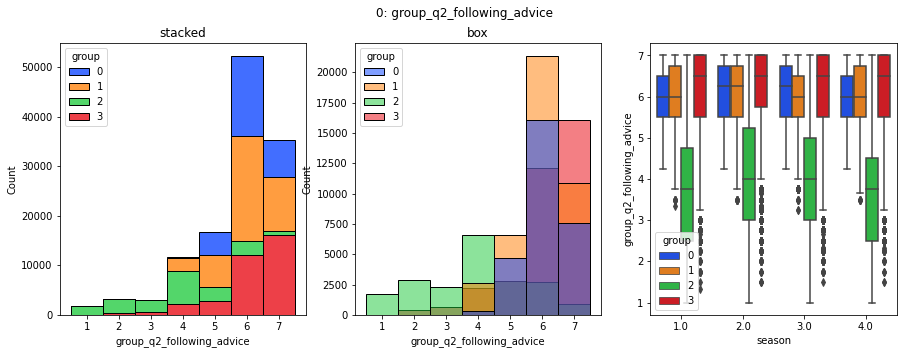

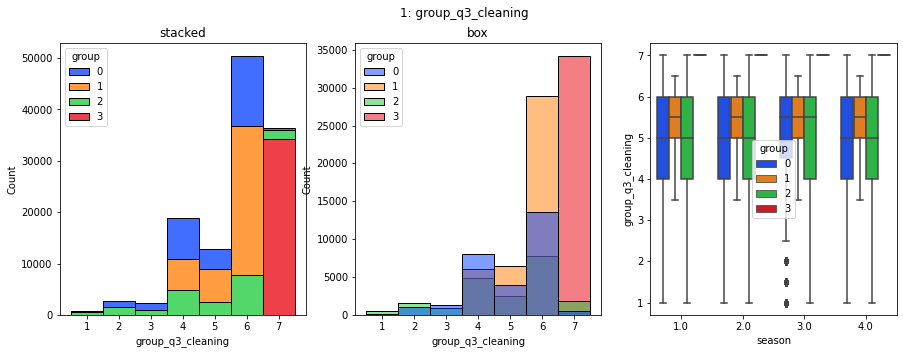

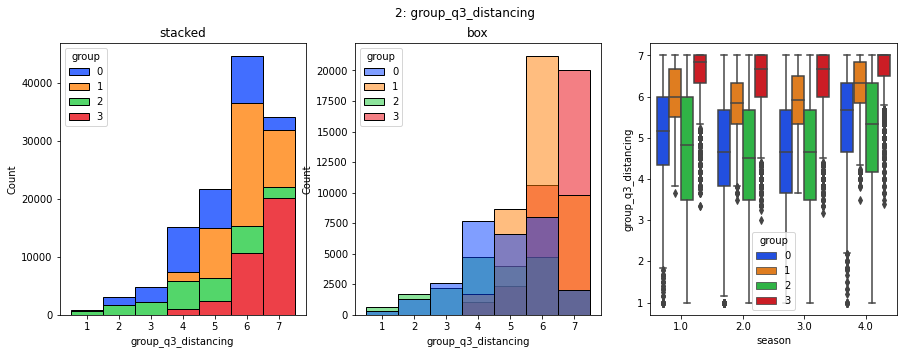

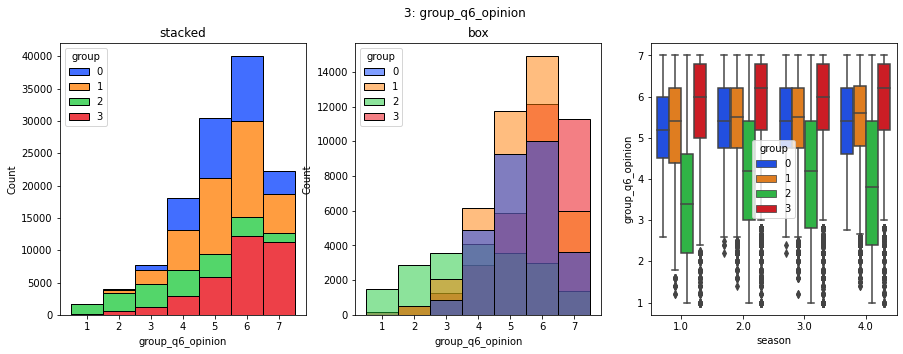

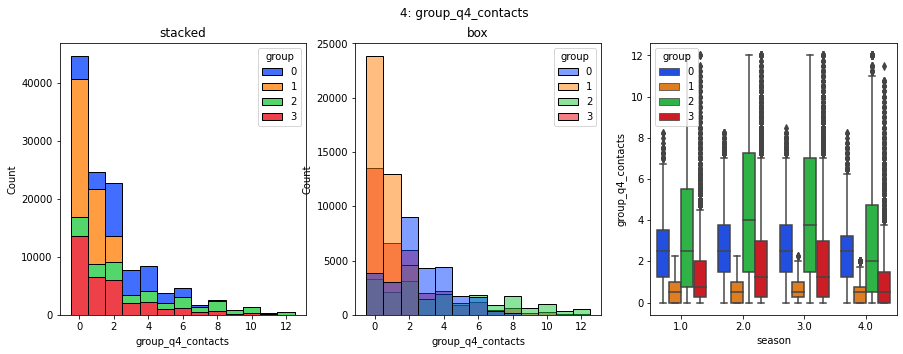

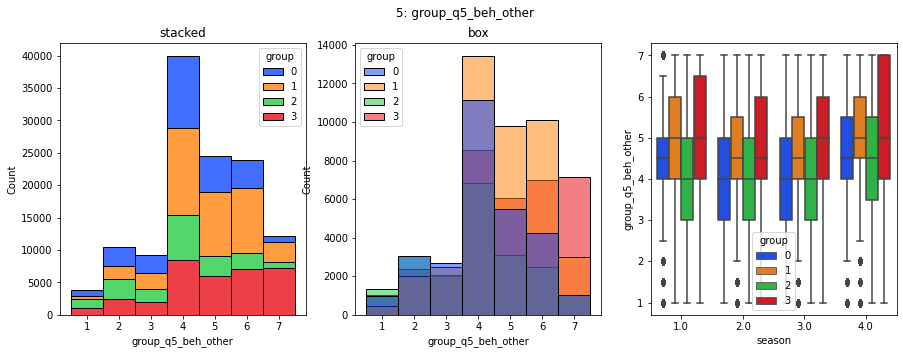

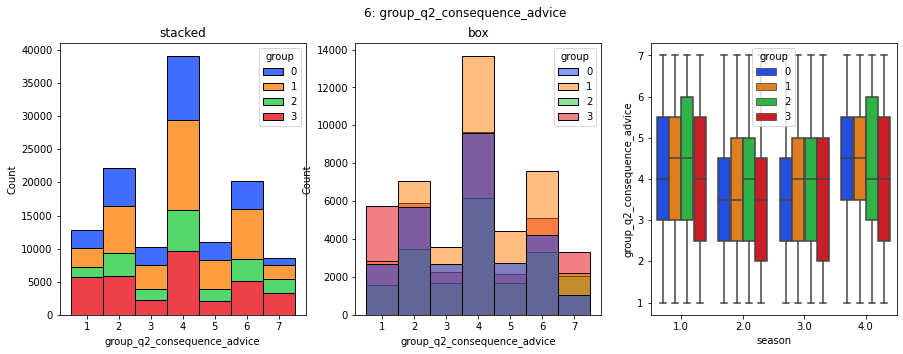

In [80]:
for i, col in enumerate(top_cols):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
    fig.suptitle(str(i)+': ' + col)
    sns.histplot(data=df.round(), x=col, hue="group", discrete=True, multiple="stack",ax=axes[0], palette='bright')
    axes[0].set_title('stacked')
    sns.histplot(data=df.round(), x=col, hue="group", discrete=True,ax=axes[1], palette='bright')
    axes[1].set_title('transparent')
    sns.boxplot(x="season", y=col, hue="group",data=df, ax=axes[2], palette='bright')
    axes[1].set_title('box')
    plt.show()

# Plot specific answers

## Create GIF

In [81]:
df_timeframe = df.copy()
df_timeframe['date'] = pd.to_datetime(df_timeframe['date'])

plt.ioff()
for nr_weeks in range(52):
  dt_start_temp = df_timeframe.date.min() + timedelta(days=7) * nr_weeks
  dt_end_temp = dt_start_temp + timedelta(days=14)
  time_window = (df_timeframe['date'] > dt_start_temp) & (df_timeframe['date'] < dt_end_temp)
  df_timeframe_temp = df_timeframe[time_window]


  g = sns.JointGrid(data=df_timeframe_temp, x=top_cols[0], y=top_cols[1], hue="group", palette='bright', height=8) # hue_order=[1, 2, 0],
  g.plot_joint(sns.kdeplot, alpha=0.8) #or scatterplot #kdeplot
  g.plot_marginals(sns.histplot, kde=True) #or kdeplot
  fig = g.fig
  fig.suptitle(dt_start_temp.strftime("%Y-%m-%d") + ' - ' + dt_end_temp.strftime("%Y-%m-%d"))
  fig.savefig("gif_creation/images/out_"+dt_start_temp.strftime("%Y_%m_%d") + ".png")
  plt.close(fig)

In [82]:
# Create GIF
images = []
path = 'gif_creation/images/'

for filename in os.listdir(path):
  images.append(imageio.imread(path+filename))
  os.remove(path+filename)
imageio.mimsave('gif_creation/gmm_grouped.gif', images, duration=0.5)

## Plot

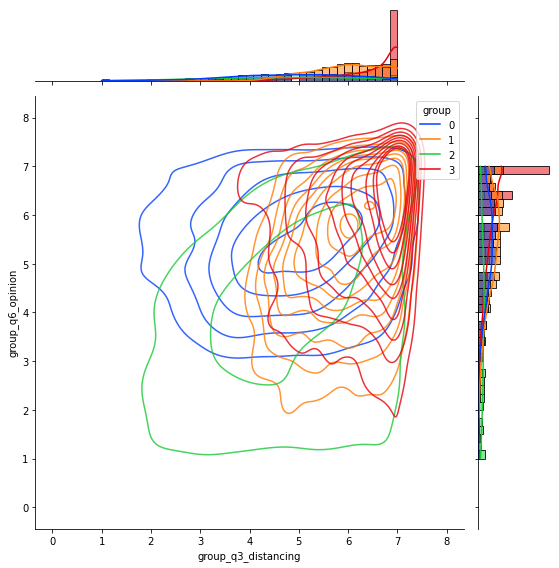

In [83]:
df_timeframe = df.sample(10000)

g = sns.JointGrid(data=df_timeframe, x=top_cols[2], y=top_cols[3], hue="group", palette='bright', height=8) # hue_order=[1, 2, 0],
g.plot_joint(sns.kdeplot, alpha=0.8) #or scatterplot #kdeplot
g.plot_marginals(sns.histplot, kde=True) #or kdeplot

In [84]:
start = '2020-12-01'
end = '2021-02-28'
df_sample.date = pd.to_datetime(df_sample.date)
in_range = (df_sample.date > start) & (df_sample.date < end)
df_sample_timewindow = df_sample[in_range]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



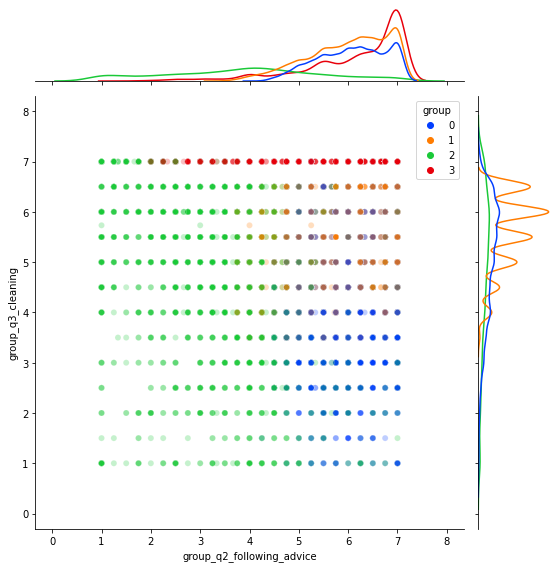

In [85]:
g = sns.JointGrid(data=df_sample, x=top_cols[0], y=top_cols[1], hue="group", palette='bright', height=8) # hue_order=[1, 2, 0],
g.plot_joint(sns.scatterplot, alpha=0.25) #or scatterplot
g.plot_marginals(sns.kdeplot) #or kdeplot

In [86]:
df_sample_timewindow.group = df_sample_timewindow.group.astype(str)
fig = px.scatter_3d(df_sample_timewindow, x=top_cols[0], y=top_cols[1], z=top_cols[2], color='group', opacity=1)
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=5, range=[1, 8],),
                     yaxis = dict(nticks=5, range=[1, 8],),
                     zaxis = dict(nticks=5, range=[1, 8],),),
        width=700, margin=dict(r=20, l=10, b=10, t=10))
fig.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Group distance # change so that it takes multiple groups into account

In [ ]:
df_dict = []
for i, day in  df[behaviour_cols + ['date', 'group']].groupby(['date']):
     groups_dist = np.abs(day[day['group']== 0].mean() - day[day['group']== 1].mean())
     dist = np.linalg.norm(groups_dist.values, ord=1)
     df_dict.append({'time':i, 'distance': dist})
dist_df = pd.DataFrame(df_dict)
dist_df['dist_smooth'] = dist_df.distance.rolling(7).mean()
fig = px.line(dist_df,x='time', y=['distance', 'dist_smooth'])
fig.show()

# Plot Group Sizes

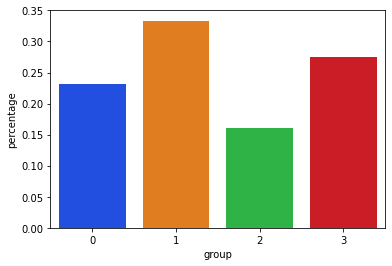

In [87]:
df_group_size = df[['group', 'gender']].groupby('group').count().reset_index()
df_group_size['gender'] = df_group_size['gender'] / df_group_size['gender'].sum()
df_group_size.rename(columns={'gender':'percentage'}, inplace=True)
sns.barplot(data=df_group_size, x='group', y='percentage', palette='bright')

# Daily distribution

In [88]:
groups_percentage = df.groupby(['date','group'],as_index=False)['gender'].count()
def normalize(row):
  sum = groups_percentage[groups_percentage['date']==row['date']]['gender'].sum()
  return row['gender']/sum

groups_percentage['percentage'] = groups_percentage.apply(lambda x: normalize(x), axis=1)
groups_percentage['date'] = pd.to_datetime(groups_percentage['date'])
groups_percentage.drop(columns='gender',inplace=True)
#fig = px.line(groups_percentage, x="date", y="percentage", color='group', title='Group daily distribution')
#fig.show()

In [89]:
df_groups_percentage = pd.DataFrame()
df_groups_percentage['date'] = groups_percentage['date'].unique()
group_cols = []
for group_nr in groups_percentage.group.unique().tolist():
  col_name = 'group_' + str(group_nr)
  df_groups_percentage[col_name] = groups_percentage[groups_percentage['group'] == group_nr].reset_index(drop=True)['percentage']
  group_cols.append(col_name)
df_groups_percentage.head()

,date,group_0,group_1,group_2,group_3
0,2020-05-29,0.129630,0.333333,0.166667,0.370370
1,2020-05-30,0.217252,0.332268,0.115016,0.335463
2,2020-05-31,0.248826,0.370892,0.140845,0.239437
3,2020-06-01,0.233542,0.322884,0.159875,0.283699
4,2020-06-02,0.234568,0.333333,0.135802,0.296296


In [90]:
df_groups_percentage[group_cols] = df_groups_percentage[group_cols].rolling(7).mean()
df_groups_percentage.iloc[10:16]

,date,group_0,group_1,group_2,group_3
10,2020-06-08,0.217446,0.368412,0.132261,0.281881
11,2020-06-09,0.216273,0.368275,0.134146,0.281305
12,2020-06-10,0.217645,0.367506,0.134314,0.280535
13,2020-06-11,0.216343,0.359052,0.138916,0.285689
14,2020-06-12,0.225052,0.345965,0.145646,0.283337
15,2020-06-13,0.237009,0.328400,0.151368,0.283223


In [91]:
px.line(df_groups_percentage, x='date', y=group_cols)

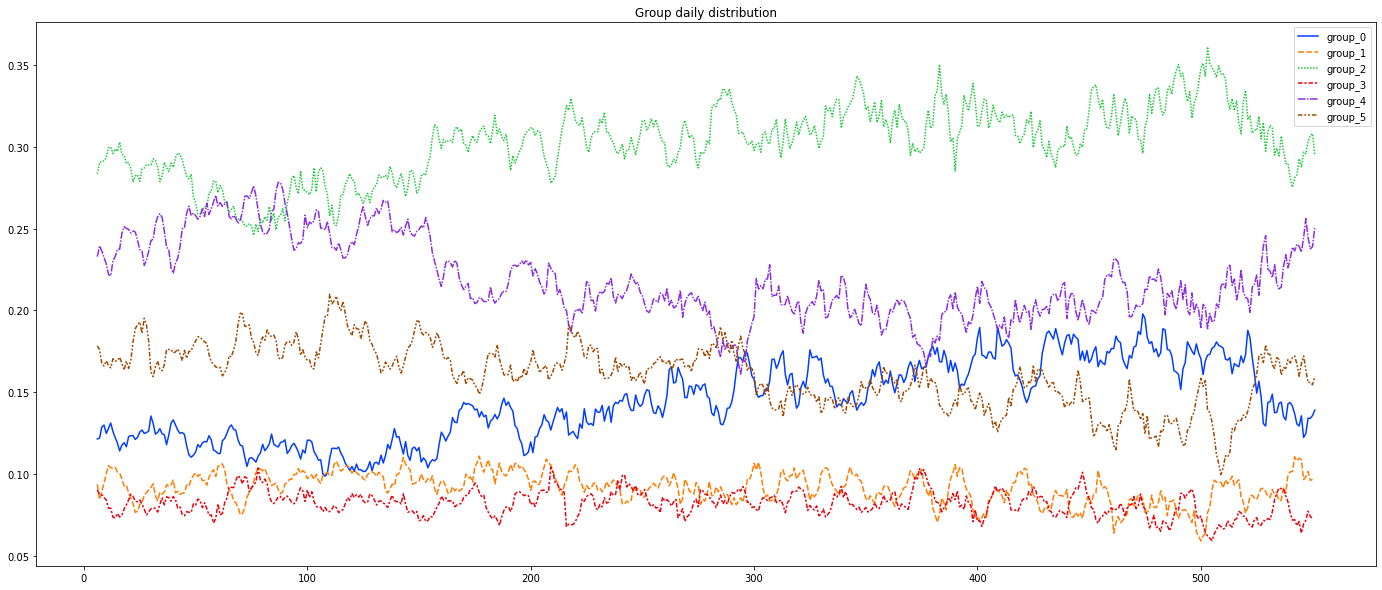

In [67]:
#fig, ax = plt.subplots(figsize=(24, 10))
#sns.lineplot(data=df_groups_percentage, palette="bright", ax=ax)
#plt.title('Group daily distribution')
#plt.show()

# Daily Average Group Answer

In [ ]:
df_daily_average = df.groupby(['date','group']).mean().reset_index()
df_daily_average.date = pd.to_datetime(df_daily_average.date)
for col in df_daily_average.columns:
    sns.lineplot(data=df_daily_average, x='date', y=col, hue='group', palette="bright")
    plt.title(col)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_daily_average = df.groupby(['date','group']).mean().reset_index()
df_daily_average_0 = df_daily_average[df_daily_average.group == 0]
df_daily_average_1 = df_daily_average[df_daily_average.group == 1]
for col in df_daily_average_0.columns:
    plt.plot(df_daily_average_0.date,df_daily_average_0[col], label='0')
    plt.plot(df_daily_average_1.date,df_daily_average_1[col], label='1')
    plt.legend()
    plt.title(col)
    plt.show()

# Observations

In [ ]:
observations = pd.read_csv('data/observations_30012022.csv',sep=';', decimal=',', encoding='utf-8')
sliced_observations = observations.iloc[92:643]
fig = px.line(sliced_observations, x="Date", y=sliced_observations.columns[2:])
fig.show()

# Archive

In [ ]:
"""for blickwinkel in np.arange(0, 270, 30):

  fig = plt.figure(figsize=(8, 8))

  ax = plt.axes(projection='3d')
  color_list = ['red', 'green', 'blue', 'yellow', 'grey']
  i=0
  x_name = top_3_cols[0]#'PC_0'
  y_name = top_3_cols[1]#'PC_3'
  z_name = top_3_cols[2]#'PC_2'
  for group in df_sample['group'].unique().tolist():
    x = df_sample[df_sample['group']==group][x_name]
    y = df_sample[df_sample['group']==group][y_name]
    z = df_sample[df_sample['group']==group][z_name]
    ax.scatter3D(x, y, z, alpha=0.1, color=color_list[i], label=str(group))
    ax.set_title('Blickwinkel: ' + str(blickwinkel) + ' Grad')
    i = i+1
  ax.legend()
  ax.set_xlabel(x_name)
  ax.set_ylabel(y_name)
  ax.set_zlabel(z_name)

  ax.azim = blickwinkel #90 #135 #180 #225 #270
  ax.elev = 40"""